In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, brier_score_loss
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb

In [4]:
f = pd.read_csv('C:\\df_data.csv')
df = pd.DataFrame(f)

# Scaling & Train-Test Split

In [5]:
y = df.pop('target')

In [6]:
X = df

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=8)

In [8]:
scaler = MinMaxScaler()
X_train_mm = scaler.fit_transform(X_train)
X_test_mm = scaler.transform(X_test)

In [9]:
X_train = pd.DataFrame(X_train_mm, columns=['age', 'campaign', 'previous', 'cons.conf.idx', 'euribor3m', 
                                            'blue_collar', 'student', 'retiree', 'unemployed', 'illiterate',
                                            'unknown_edu', 'university', 'basic4','basic_other', 'single', 
                                            'no_default', 'age_retiree', 'age_student', 'age_basic4', 
                                            'age_illiterate', 'poutcome_nonexistent', 'poutcome_success', 
                                            'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 
                                            'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 
                                            'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 
                                            'day_of_week_wed'])

In [10]:
X_test = pd.DataFrame(X_test_mm, columns=['age', 'campaign', 'previous', 'cons.conf.idx', 'euribor3m', 
                                          'blue_collar', 'student', 'retiree', 'unemployed', 'illiterate',
                                          'unknown_edu', 'university', 'basic4','basic_other', 'single',
                                          'no_default', 'age_retiree', 'age_student', 'age_basic4', 
                                          'age_illiterate', 'poutcome_nonexistent', 'poutcome_success', 
                                          'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 
                                          'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 
                                          'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 
                                          'day_of_week_wed'])

# Calibration CV Gridsearch

#### Will evaluate 5 classification models: _Logistic regression, NaiveBayes, Random Forest, SVC & XGBoost_

In [11]:
# Dictionary of classifiers using the tuned model parameters
clf_dict = {
    'Logistic Regression': LogisticRegression(C=0.1, class_weight='balanced', max_iter=3000, penalty='l1', 
                           solver='liblinear', random_state=8),
    'Naive Bayes': GaussianNB(var_smoothing=0.0001, priors=None), 
    'Random Forest': RandomForestClassifier(class_weight='balanced', criterion='entropy', max_features='log2', 
                                            min_samples_split=30, n_estimators=175, random_state=8),
    'SV Classification': SVC(C=1000, kernel='rbf', gamma=0.01, class_weight='balanced', 
                             max_iter=200000, random_state=8), 
    'XG Boost' : xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=10, gpu_id=-1, importance_type='gain', objective='binary:logistic',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, monotone_constraints='()', n_estimators=20, n_jobs=12,
              num_parallel_tree=1, random_state=8, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=5, seed=8, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None, use_label_encoder=False)  
}

In [12]:
def prob_calibration(X_train, y_train, X_test, y_test, dictionary, new_dictionary, verbose=True):
    '''
    Fits a dictionary of algorithms, run calibration, capture best_estimators, & generate calibration curves
    '''
    # Setting the calibration plot parameters
    plt.figure(figsize=(12, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    # Loop through dictionary items
    for key, clf in dictionary.items():
   
        # Set calibration parameters     
        calibrated = CalibratedClassifierCV(clf, cv=3)        
        param_grid = dict(method=['sigmoid','isotonic'])
        
        # Gridsearch on best probability scaling regressor
        kf = StratifiedKFold(n_splits=3)
        clf_grid = GridSearchCV(estimator=calibrated, param_grid=param_grid, n_jobs=-1, 
                                cv=kf, scoring='brier_score_loss') # Tuned according to Brier loss scorer
        clf_grid = clf_grid.fit(X_train, y_train)
        
        # Populating new dictionary with the Gridsearch best_estimators
        new_dictionary[key] = clf_grid.best_estimator_
        print('{} optimal calibration {}'.format(key, clf_grid.best_params_))
         
        # Retrieving predicted probabilities
        clf_grid.best_estimator_.fit(X_train, y_train)

        if hasattr(clf_grid.best_estimator_, "predict_proba"):
            prob_pos = clf_grid.best_estimator_.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf_grid.best_estimator_.decision_function(X_test)
            prob_pos = (prob_pos - prob_pos.min())/(prob_pos.max() - prob_pos.min())
   
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (key, ))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=key,
             histtype="step", lw=2)
    
    # Generate calibration curves
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="upper left", fontsize=12)
    ax1.set_title('Calibration Curves of the Respective Algorithms', fontsize=18)

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper right", ncol=2, fontsize=12)

    plt.tight_layout()
    plt.show()


In [13]:
# Using only the training data as split initially for the calibration train-validation tuning
X_train_cab, X_test_cab, y_train_cab, y_test_cab = train_test_split(X_train, y_train, 
                                                                    stratify=y_train, test_size=0.3, random_state=8)

In [14]:
# Create an empty dictionary to contain the probability scaled models
clf_cal_dict = {}

Logistic Regression optimal calibration {'method': 'isotonic'}
Naive Bayes optimal calibration {'method': 'isotonic'}
Random Forest optimal calibration {'method': 'isotonic'}


C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SV Classification optimal calibration {'method': 'sigmoid'}


C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


XG Boost optimal calibration {'method': 'isotonic'}


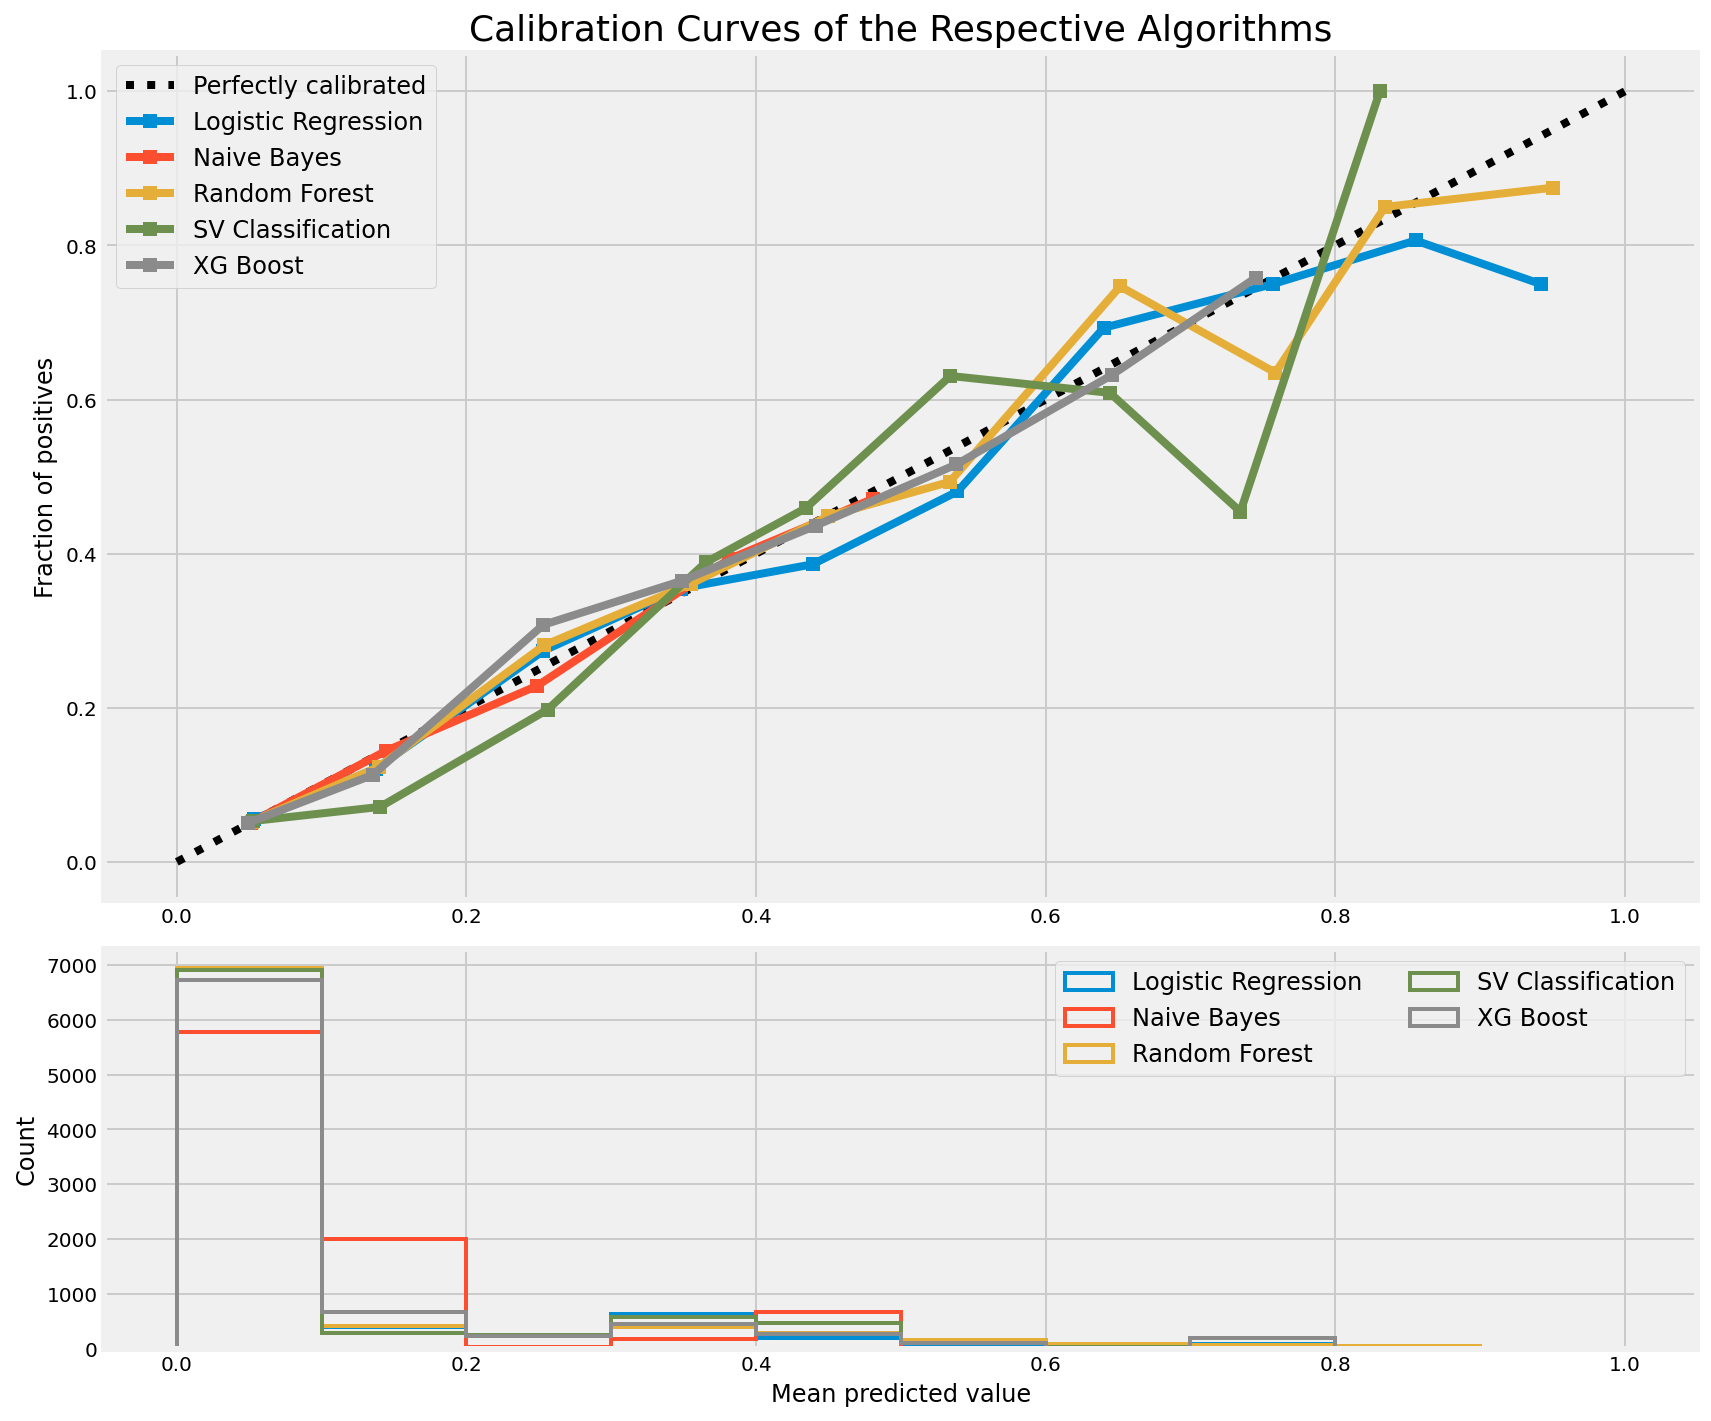

In [15]:
prob_calibration(X_train_cab, y_train_cab, X_test_cab, y_test_cab, clf_dict, clf_cal_dict)

Dropping the **Naive Bayes** from here because it still shows extremely poor calibrated probabilities. Only **SVC** has better calibration using the "sigmoid" method. The rest are better with the "isotonic" (or logistic regression) method.

In [16]:
del clf_cal_dict['Naive Bayes']

In [17]:
clf_cal_dict

{'Logistic Regression': CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.1,
                                                          class_weight='balanced',
                                                          max_iter=3000,
                                                          penalty='l1',
                                                          random_state=8,
                                                          solver='liblinear'),
                        cv=3, method='isotonic'),
 'Random Forest': CalibratedClassifierCV(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                              criterion='entropy',
                                                              max_features='log2',
                                                              min_samples_split=30,
                                                              n_estimators=175,
                                               

# Getting Predicted Probabilities on Training Set

In [18]:
def prob_predictions(X, y, dictionary):
    '''
    Fits a dictionary of algorithms, get predicted probabilities, & populate DF with probabilities
    '''  
    # Empty dictionary with keys according to the clf models
    adf = pd.DataFrame(columns=dictionary.keys()) # Columns of DF will accord with dictionary keys
    
    for key, clf in dictionary.items():
        clf.fit(X, y)
        
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X)[:, 1] # The predicted probabilities are in a Numpy array
        else:
            prob_pos = clf.decision_function(X)
            prob_pos = (prob_pos - prob_pos.min())/(prob_pos.max() - prob_pos.min())
            
        # Appending Numpy array of probabilities to Pandas Dataframe
        adf[key] = pd.Series(prob_pos).transpose()
        
    return adf

In [19]:
train_probabilities = prob_predictions(X_train, y_train, clf_cal_dict)

C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\camb7\anaconda3\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [20]:
train_probabilities

,Logistic Regression,Random Forest,SV Classification,XG Boost
0,0.047662,0.058791,0.060786,0.040450
1,0.070682,0.048459,0.049222,0.055567
2,0.039140,0.041793,0.046926,0.048849
3,0.047662,0.076096,0.050343,0.043815
4,0.343986,0.441660,0.403847,0.429653
...,...,...,...,...
28818,0.140958,0.078616,0.206671,0.164454
28819,0.390503,0.418217,0.438100,0.433672
28820,0.062918,0.230244,0.055065,0.075884
28821,0.049694,0.045875,0.049320,0.050058


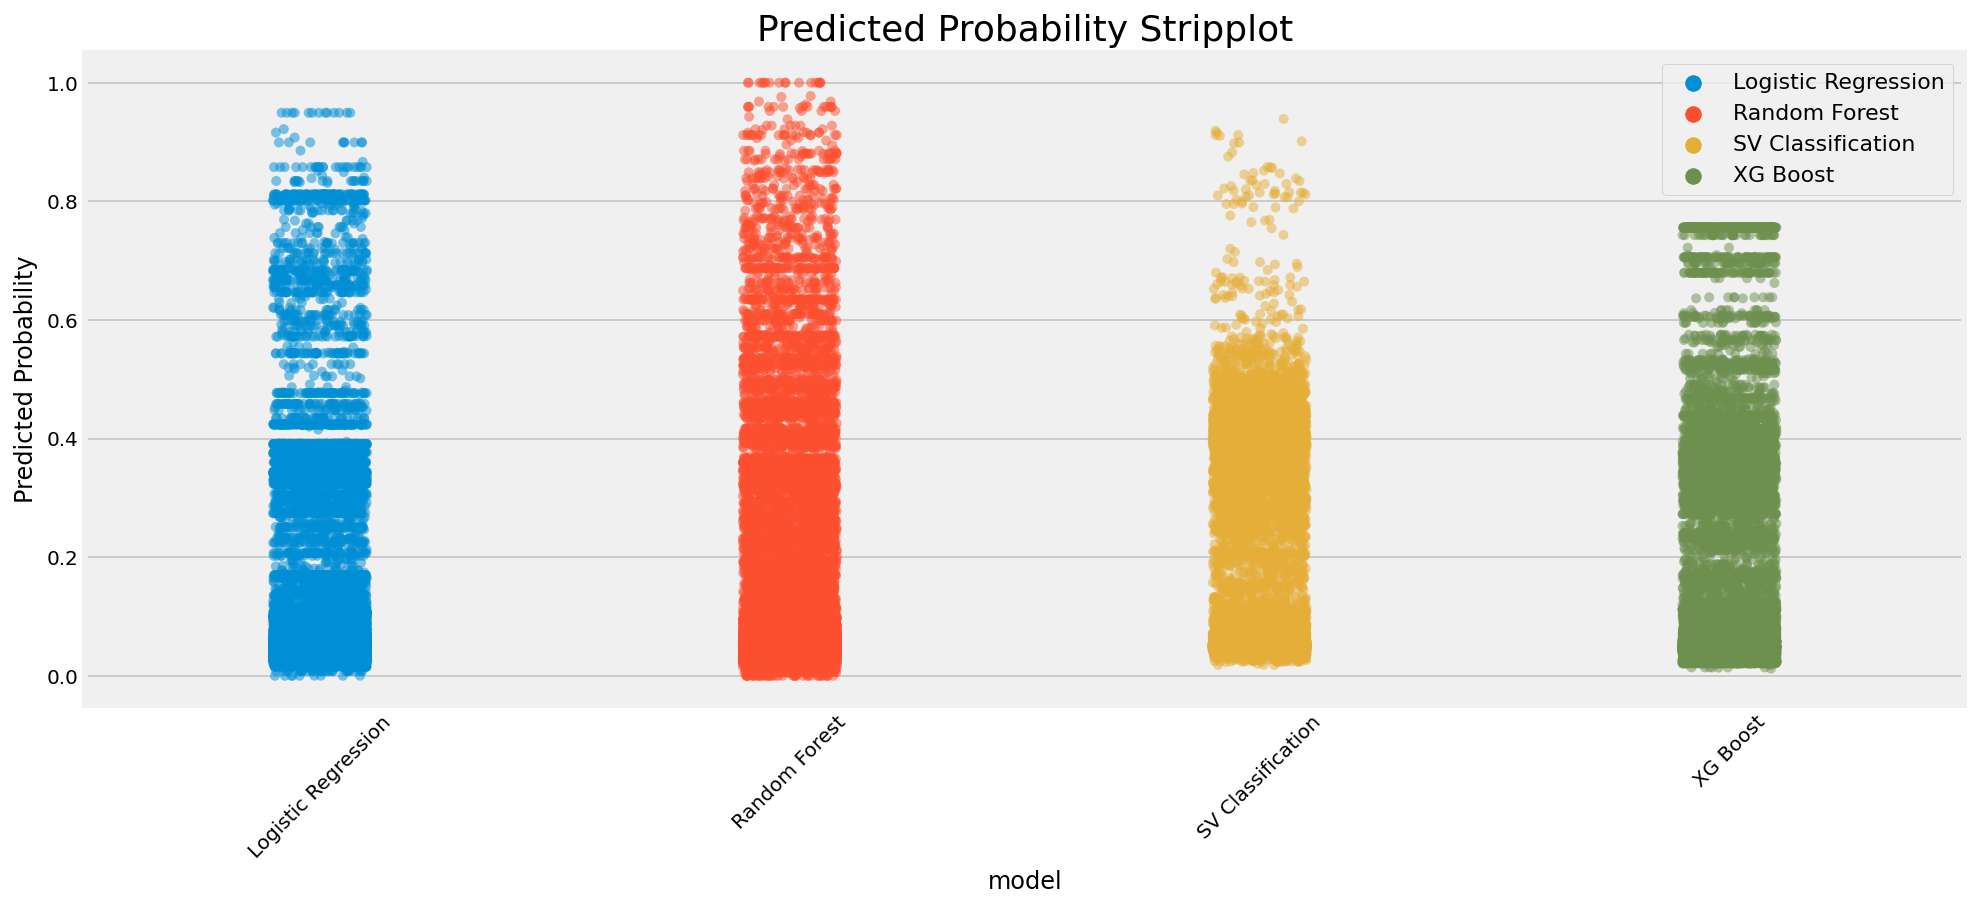

In [21]:
fig, ax = plt.subplots(figsize=(15,6))

df_melt = pd.melt(train_probabilities, var_name='model', value_name='probabilities')
sns.stripplot(x='model', y='probabilities', data=df_melt, hue='model', jitter=0.1, alpha=0.5, ax=ax)

ax.set_ylabel("Predicted Probability")
ax.legend(loc="upper right", fontsize=11)
ax.set_ylim([-0.05, 1.05])
plt.title('Predicted Probability Stripplot', fontsize=18)
plt.xticks(rotation=45)
plt.show()

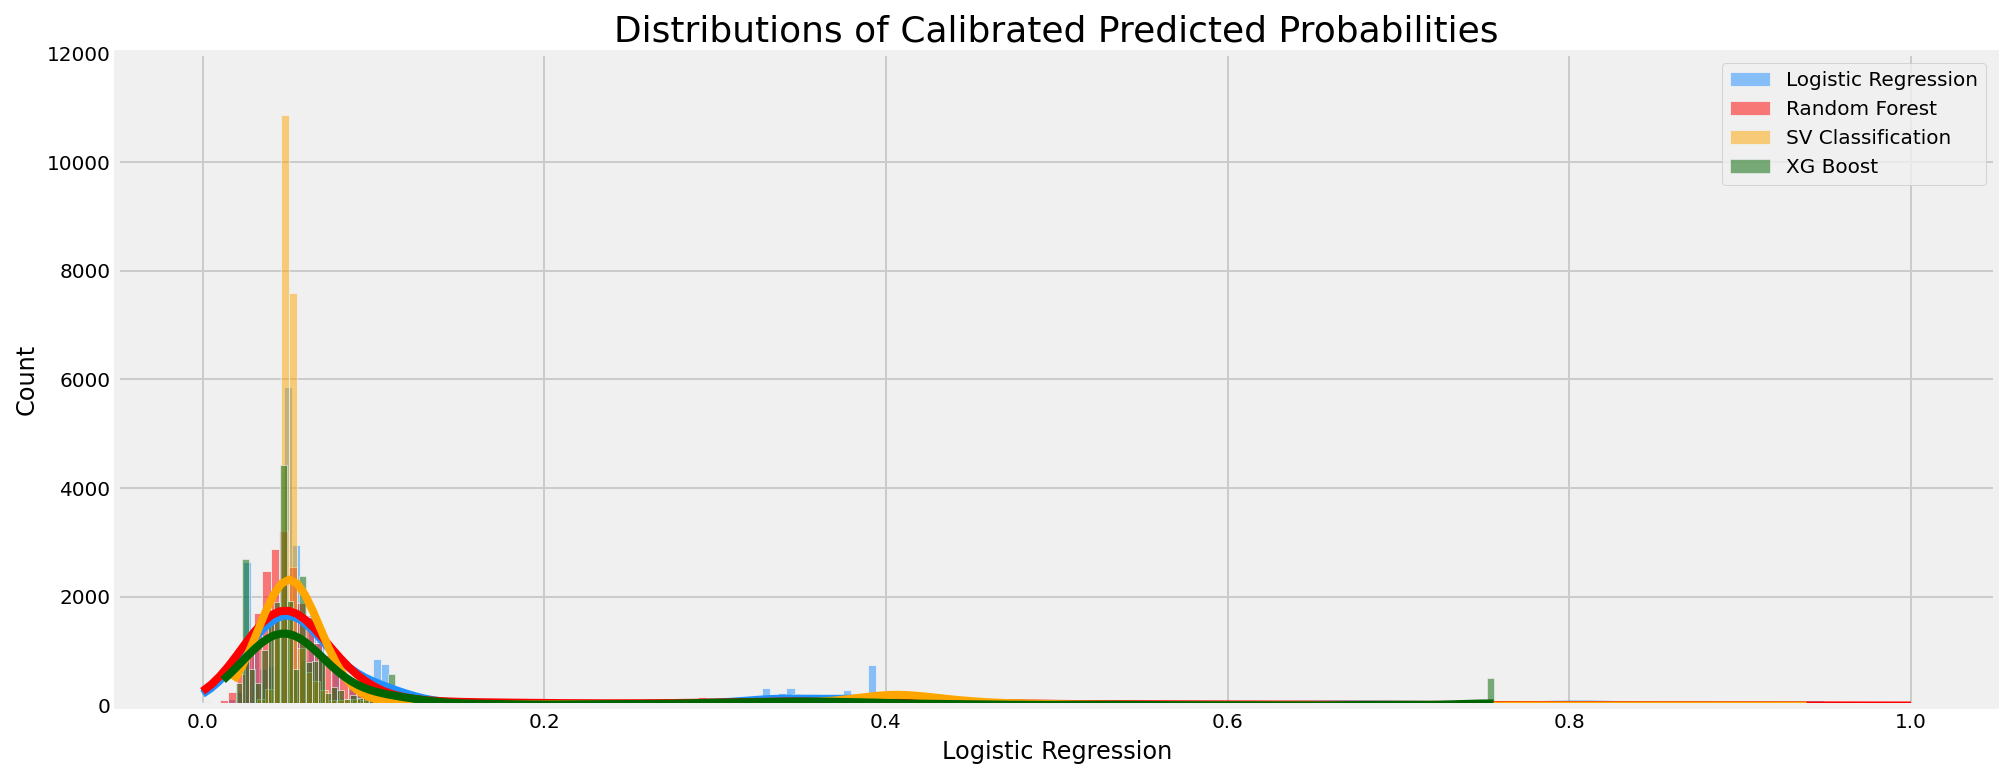

In [22]:
fig, ax = plt.subplots(figsize=(15,6))

sns.histplot(train_probabilities['Logistic Regression'], bins=200, kde=True, ax=ax, 
             color='dodgerblue', label='Logistic Regression')
sns.histplot(train_probabilities['Random Forest'], bins=200, kde=True, ax=ax, 
             color='red', label='Random Forest')
sns.histplot(train_probabilities['SV Classification'], bins=200, kde=True, ax=ax, 
             color='orange', label='SV Classification')
sns.histplot(train_probabilities['XG Boost'], bins=200, kde=True, ax=ax, 
             color='darkgreen', label='XG Boost')

ax.yaxis.set_ticks(np.arange(0.00, 13000, 2000))
ax.legend(loc="upper right", fontsize=12)
plt.title('Distributions of Calibrated Predicted Probabilities', fontsize=18)
plt.legend();

# Altering Probability Thresholds

In [23]:
def f1_threshold(precision, recall):
    numer = 2 * recall * precision
    denom = recall + precision
    f1_scores = np.divide(numer, denom, out=np.zeros_like(denom), where=(denom!=0))
    max_f1 = np.max(f1_scores)
    max_f1_thresh = thresholds[np.argmax(f1_scores)]
    
    print("Maximum F1 score: {:0.4f}".format(max_f1))
    print("Optimal probability threshold: {:0.4f}".format(max_f1_thresh))
    return max_f1_thresh

## Logistic Regression

In [24]:
precision, recall, thresholds = precision_recall_curve(y_train, train_probabilities['Logistic Regression'], 
                                                       pos_label=1)
thresholds = np.append(thresholds, 1) 

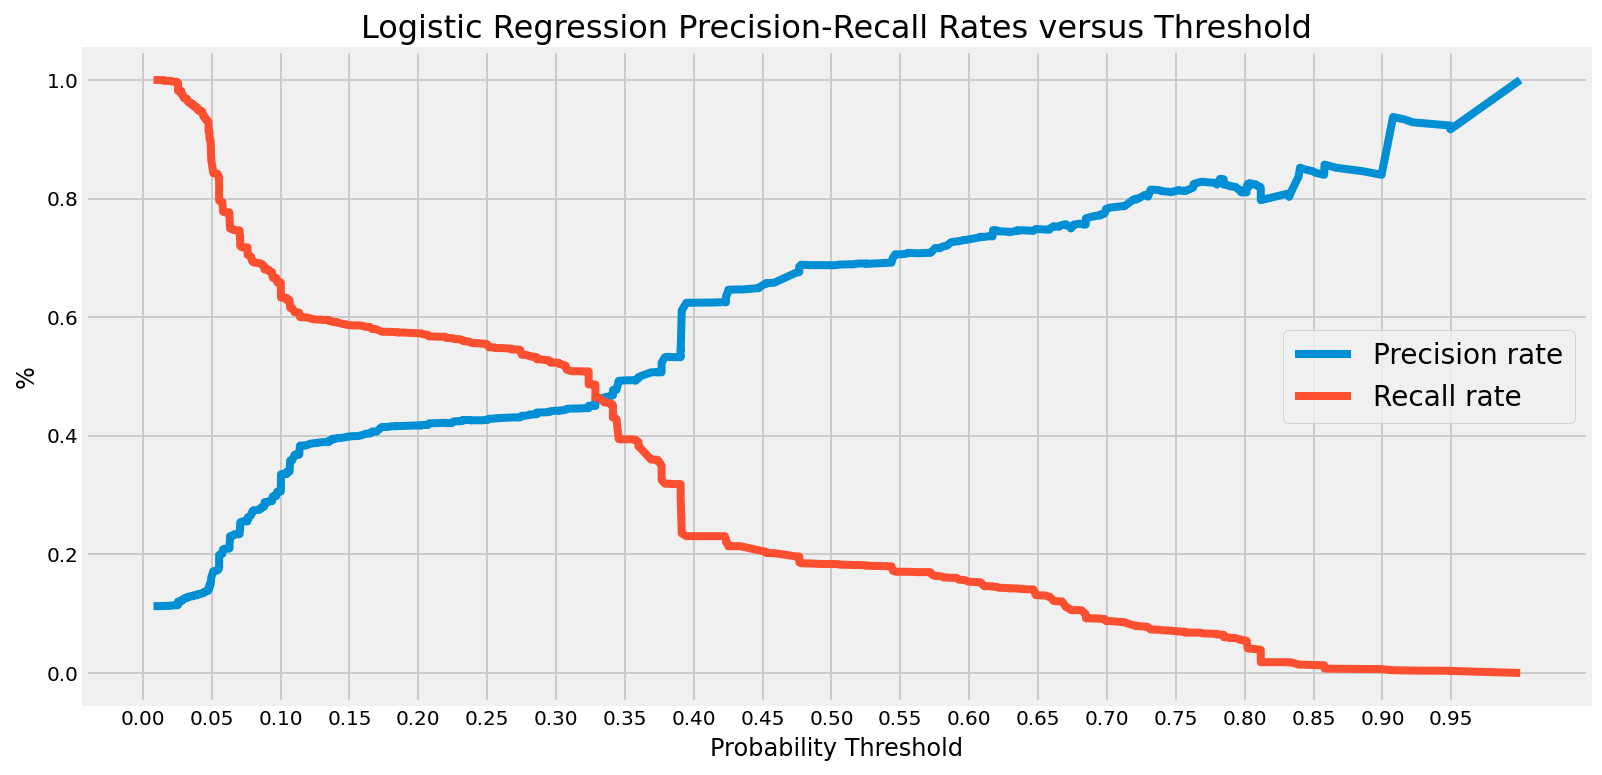

In [25]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(thresholds, precision, color=sns.color_palette()[0]) 
ax.plot(thresholds, recall, color=sns.color_palette()[1]) 
ax.legend(('Precision rate', 'Recall rate'), fontsize=14)

ax.set_title("Logistic Regression Precision-Recall Rates versus Threshold", fontsize=16)
ax.set_xlabel('Probability Threshold')
ax.xaxis.set_ticks(np.arange(0.00, 1.00, 0.05))
ax.set_ylabel('%');

In [26]:
threshold = f1_threshold(precision, recall)

Maximum F1 score: 0.4843
Optimal probability threshold: 0.2316


In [27]:
threshold

0.23162814197296955

In [28]:
p_list = train_probabilities['Logistic Regression'].tolist()
logit_train_class = [1 if i > threshold else 0 for i in p_list]

In [29]:
p_list = clf_cal_dict['Logistic Regression'].predict_proba(X_test)[:, 1].tolist()
logit_test_class = [1 if i > threshold else 0 for i in p_list]

## Random Forest

In [30]:
precision, recall, thresholds = precision_recall_curve(y_train, train_probabilities['Random Forest'], 
                                                       pos_label=1)
thresholds = np.append(thresholds, 1) 

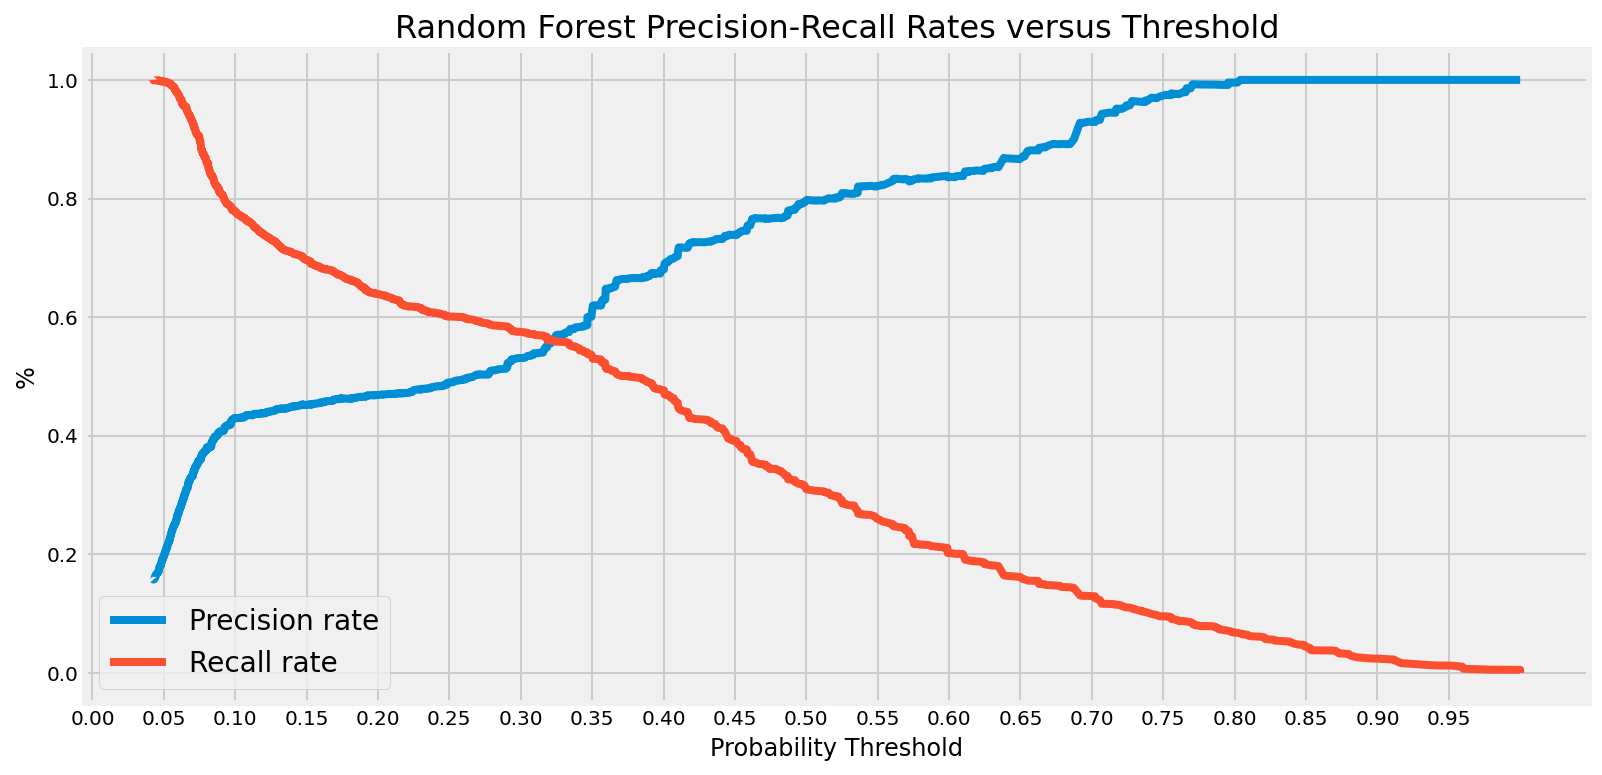

In [31]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(thresholds, precision, color=sns.color_palette()[0]) 
ax.plot(thresholds, recall, color=sns.color_palette()[1]) 
ax.legend(('Precision rate', 'Recall rate'), fontsize=14)

ax.set_title("Random Forest Precision-Recall Rates versus Threshold", fontsize=16)
ax.set_xlabel('Probability Threshold')
ax.xaxis.set_ticks(np.arange(0.00, 1.00, 0.05))
ax.set_ylabel('%');

In [32]:
threshold = f1_threshold(precision, recall)

Maximum F1 score: 0.5743
Optimal probability threshold: 0.3597


In [33]:
p_list = train_probabilities['Random Forest'].tolist()
rf_train_class = [1 if i > threshold else 0 for i in p_list]

In [34]:
p_list = clf_cal_dict['Random Forest'].predict_proba(X_test)[:, 1].tolist()
rf_test_class = [1 if i > threshold else 0 for i in p_list]

## SVC

In [35]:
precision, recall, thresholds = precision_recall_curve(y_train, train_probabilities['SV Classification'], 
                                                       pos_label=1)
thresholds = np.append(thresholds, 1)

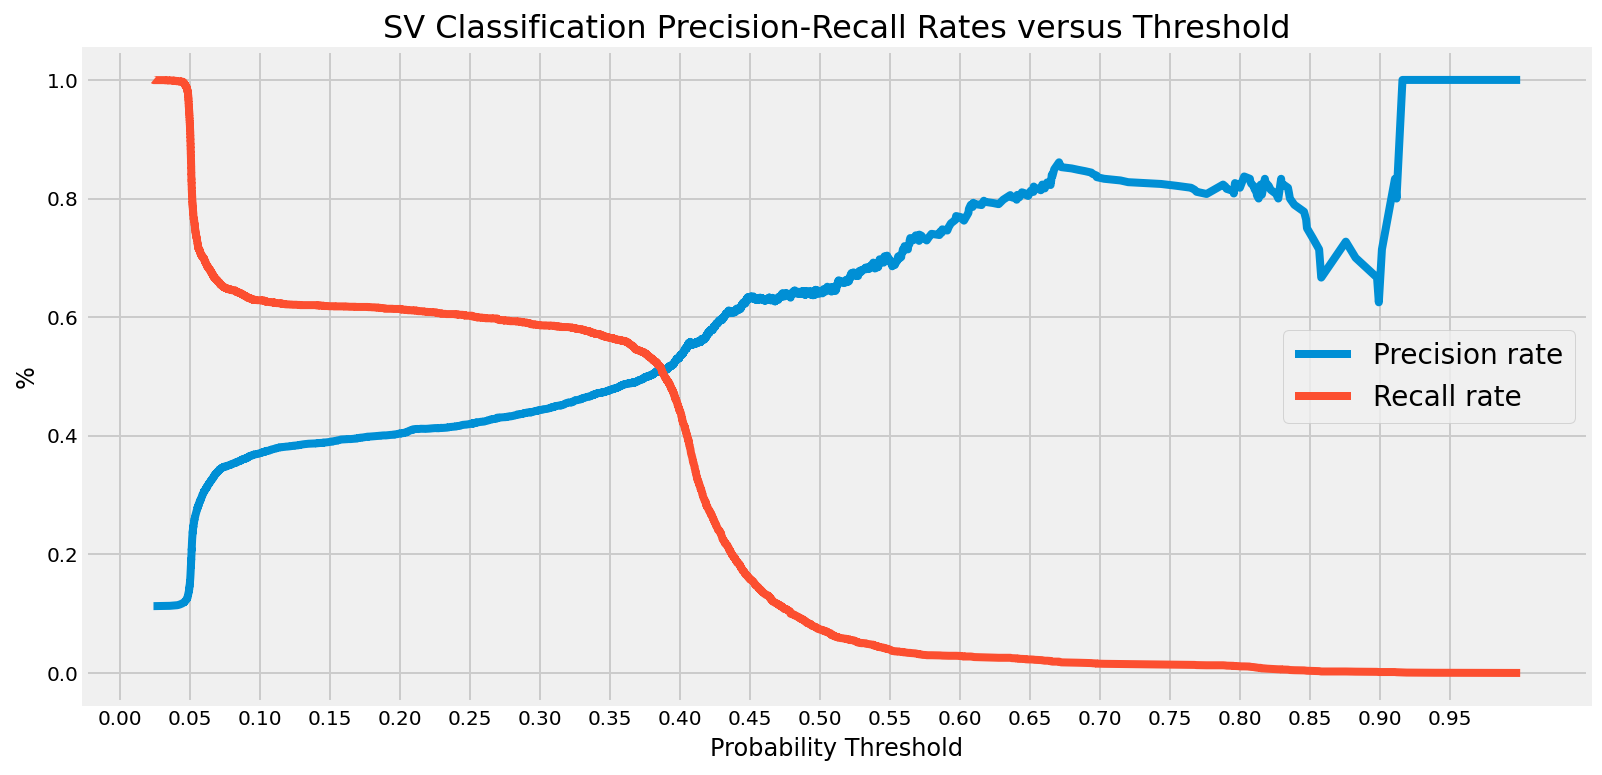

In [36]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(thresholds, precision, color=sns.color_palette()[0]) 
ax.plot(thresholds, recall, color=sns.color_palette()[1]) 
ax.legend(('Precision rate', 'Recall rate'), fontsize=14)

ax.set_title("SV Classification Precision-Recall Rates versus Threshold", fontsize=16)
ax.set_xlabel('Probability Threshold') 
ax.xaxis.set_ticks(np.arange(0.00, 1.00, 0.05))
ax.set_ylabel('%');

In [37]:
threshold = f1_threshold(precision, recall)

Maximum F1 score: 0.5209
Optimal probability threshold: 0.3606


In [38]:
p_list = train_probabilities['SV Classification'].tolist()
svc_train_class = [1 if i > threshold else 0 for i in p_list]

In [39]:
p_list = clf_cal_dict['SV Classification'].predict_proba(X_test)[:, 1].tolist()
svc_test_class = [1 if i > threshold else 0 for i in p_list]

## XG Boost

In [40]:
precision, recall, thresholds = precision_recall_curve(y_train, train_probabilities['XG Boost'], 
                                                       pos_label=1)
thresholds = np.append(thresholds, 1) 

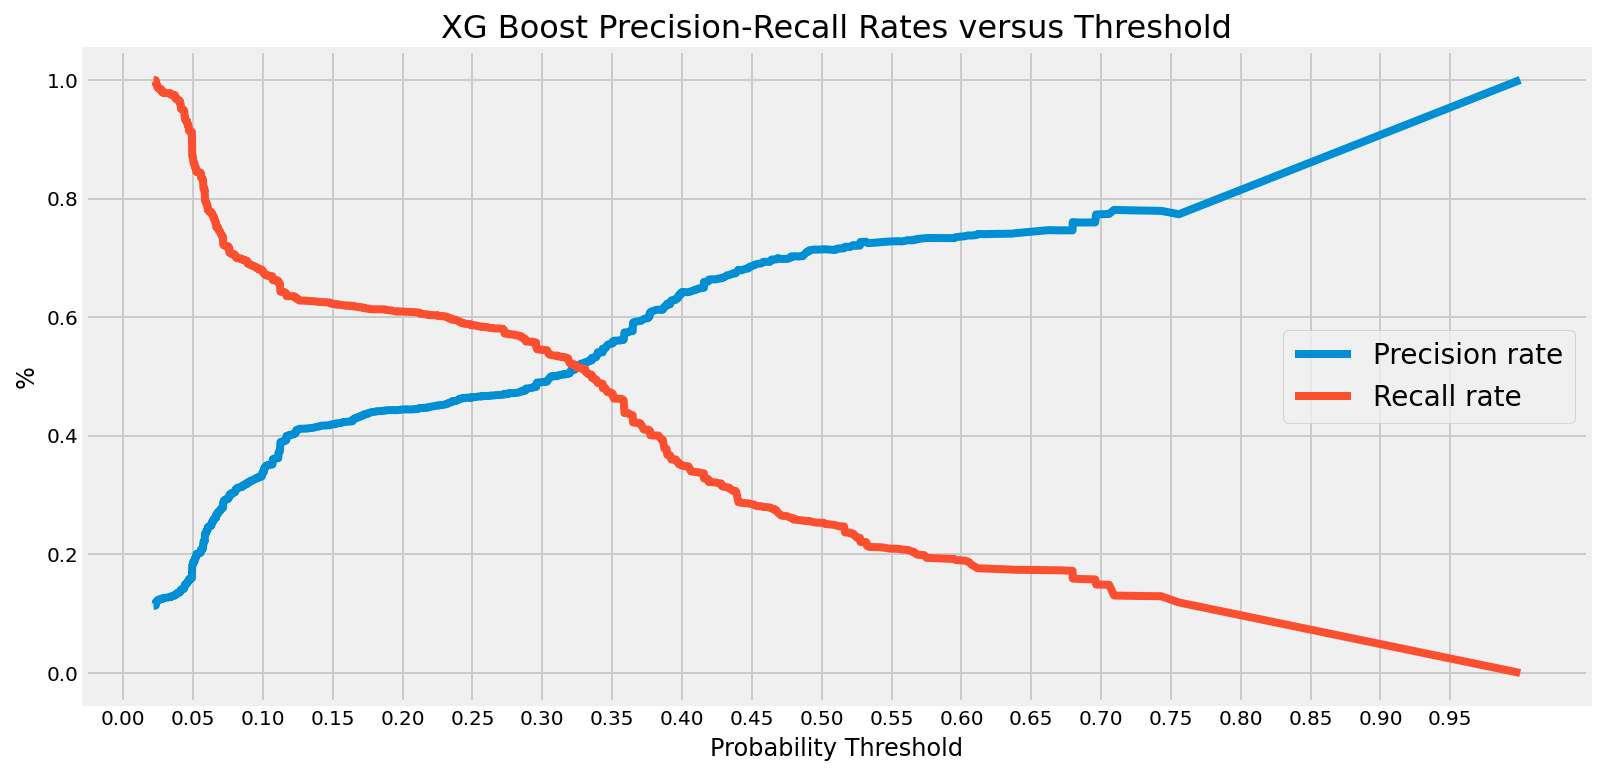

In [41]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(thresholds, precision, color=sns.color_palette()[0]) 
ax.plot(thresholds, recall, color=sns.color_palette()[1]) 
ax.legend(('Precision rate', 'Recall rate'), fontsize=14)

ax.set_title("XG Boost Precision-Recall Rates versus Threshold", fontsize=16)
ax.set_xlabel('Probability Threshold')
ax.xaxis.set_ticks(np.arange(0.00, 1.00, 0.05))
ax.set_ylabel('%');

In [42]:
threshold = f1_threshold(precision, recall)

Maximum F1 score: 0.5191
Optimal probability threshold: 0.2408


In [43]:
p_list = train_probabilities['XG Boost'].tolist()
xgb_train_class = [1 if i > threshold else 0 for i in p_list]

In [44]:
p_list = clf_cal_dict['XG Boost'].predict_proba(X_test)[:, 1].tolist()
xgb_test_class = [1 if i > threshold else 0 for i in p_list]

# Comparative Test Scoring

In [45]:
calibrated_train_results = pd.DataFrame(
                                    {'Logistic Regression': logit_train_class,
                                     'Random Forest': rf_train_class,
                                     'SV Classification': svc_train_class,
                                     'XG Boost': xgb_train_class
                                    })

In [46]:
calibrated_test_results = pd.DataFrame(
                                    {'Logistic Regression': logit_test_class,
                                     'Random Forest': rf_test_class,
                                     'SV Classification': svc_test_class,
                                     'XG Boost': xgb_test_class
                                    })

In [47]:
def batch_tests(df_train, df_test, y_train, y_test):
    '''
    Loops through dictionaries of predicted classes and scores them against the actual class observations,
    in both the train and test sets
    '''
    train_f1_scores = []
    test_f1_scores = []
    train_cohen_scores = []
    test_cohen_scores = []
    train_pre_scores = []
    test_pre_scores = []
    train_acc_scores = []
    test_acc_scores = []
    
    for i in df_train: # iterate over columns of df_train
        
        #Get F1 scores
        train_f1 = f1_score(y_train, df_train[i], average='binary')
        train_f1_scores.append(round(train_f1,4))
        
        # Get Cohen's kappa
        train_cohen = cohen_kappa_score(y_train, df_train[i])
        train_cohen_scores.append(round(train_cohen,4))
        
        # Get AUC of precision-recall curves
        train_pre = average_precision_score(y_train, df_train[i], average='macro')
        train_pre_scores.append(round(train_pre,4))
        
        #Get accuracy scores
        train_acc = accuracy_score(y_train, df_train[i])
        train_acc_scores.append(round(train_acc,4))
        

    for j in df_test: # iterate over columns of df_test
        
        #Get F1 scores
        test_f1 = f1_score(y_test, df_test[j], average='binary')
        test_f1_scores.append(round(test_f1,4))
        
        # Get Cohen's kapp
        test_cohen = cohen_kappa_score(y_test, df_test[j])
        test_cohen_scores.append(round(test_cohen,4))
        
        # Get AUC of precision-recall curves
        test_pre = average_precision_score(y_test, df_test[j], average='macro')
        test_pre_scores.append(round(test_pre,4))           
                
        #Get accuracy scores
        test_acc = accuracy_score(y_test, df_test[j])
        test_acc_scores.append(round(test_acc,4))
        
    # Create results dataframe
    results = pd.DataFrame({'Model': list(clf_cal_dict.keys()), 
                            'Train F1': train_f1_scores,
                            'Test F1': test_f1_scores,
                            "Train Cohen's kappa" : train_cohen_scores,
                            "Test Cohen's kappa" : test_cohen_scores,
                            'Train PR-AUC': train_pre_scores,
                            'Test PR-AUC': test_pre_scores,
                            'Train Accuracy': train_acc_scores,
                            'Test Accuracy': test_acc_scores,
                            })

    return results

In [48]:
batch_tests(calibrated_train_results, calibrated_test_results, y_train, y_test)

,Model,Train F1,Test F1,Train Cohen's kappa,Test Cohen's kappa,Train PR-AUC,Test PR-AUC,Train Accuracy,Test Accuracy
0,Logistic Regression,0.4841,0.4904,0.4082,0.4152,0.2883,0.2938,0.8652,0.8663
1,Random Forest,0.5726,0.4528,0.5253,0.3947,0.3872,0.2778,0.9137,0.8926
2,SV Classification,0.5207,0.4890,0.4550,0.4200,0.3221,0.2942,0.8839,0.8780
3,XG Boost,0.5190,0.5057,0.4494,0.4344,0.3195,0.3074,0.8765,0.8736


The **training** F1 and Cohen's kappa scores showed improvements across all four models. The **test scores** are more important of course, and they show **a general improvement after the threshold adjustment**, except for the Random Forest algorithm.

The threshold adjustment boosted the Logit model's test scores notably across F1, Cohen's kappa and precision-recall AUC metrics. There were more moderate increases in the SVC and XG Boost model scores across these three metrics.

However, the **XG Boost algorithm retained its crown as the top performer** with the best test scores across the three metrics. **SVC was the runner-up** based on the train and test scores, but **Logit was a very close third in the test scores** with a marginally higher F1 score but lower Cohen's kappa and AUC-PR.

Interestingly, the **test accuracy scores rose for all four models**, even though it was never a focus during the gridsearch and calibration measures. So the probability threshold adjustment not only improved the model predictions on the minority class 1, except for RF, but also on the models' overall accuracy across classes 1 and 0.

# Confusion Matrices

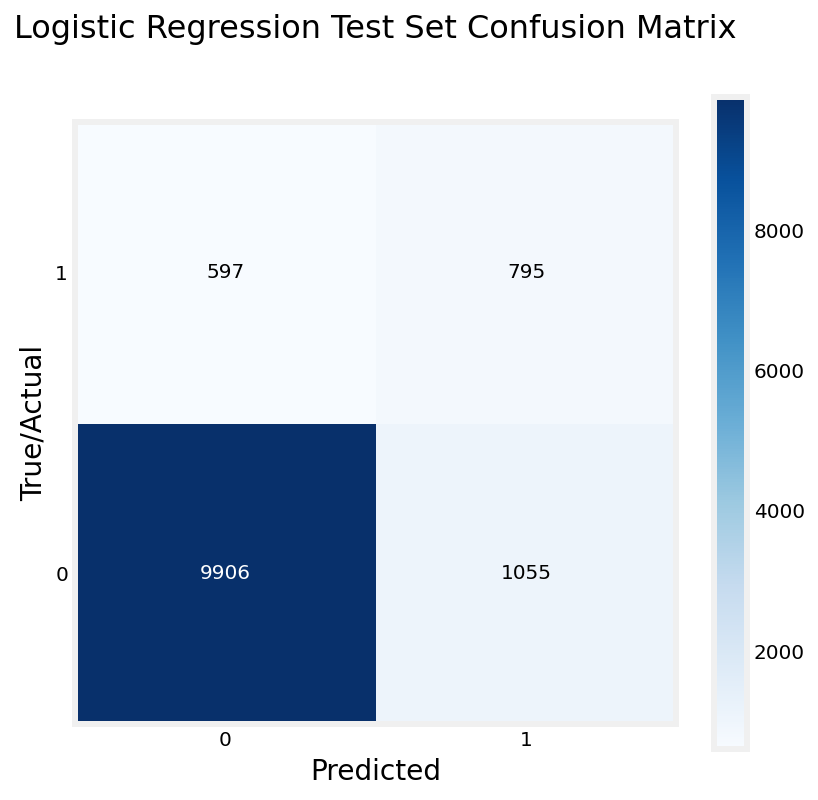

In [49]:
# Logit confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, logit_test_class, figsize=(6,6))
plt.title('Logistic Regression Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [50]:
print(metrics.classification_report(y_test, logit_test_class))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     10961
           1       0.43      0.57      0.49      1392

    accuracy                           0.87     12353
   macro avg       0.69      0.74      0.71     12353
weighted avg       0.89      0.87      0.87     12353



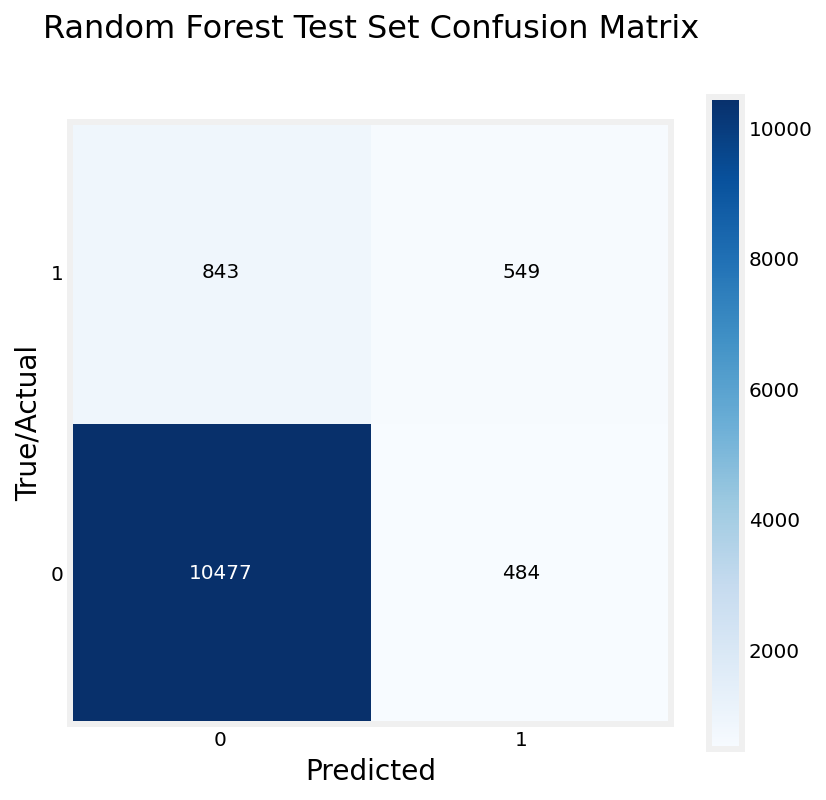

In [51]:
# RF confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, rf_test_class, figsize=(6,6))
plt.title('Random Forest Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [52]:
print(metrics.classification_report(y_test, rf_test_class))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     10961
           1       0.53      0.39      0.45      1392

    accuracy                           0.89     12353
   macro avg       0.73      0.68      0.70     12353
weighted avg       0.88      0.89      0.89     12353



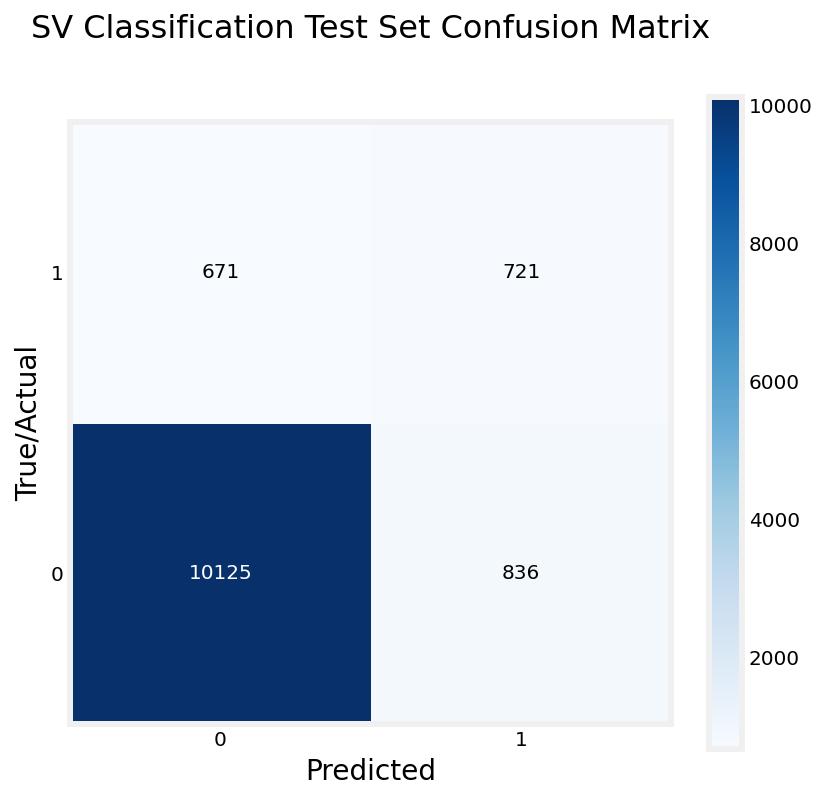

In [53]:
# SVC confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, svc_test_class, figsize=(6,6))
plt.title('SV Classification Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [54]:
print(metrics.classification_report(y_test, svc_test_class))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10961
           1       0.46      0.52      0.49      1392

    accuracy                           0.88     12353
   macro avg       0.70      0.72      0.71     12353
weighted avg       0.88      0.88      0.88     12353



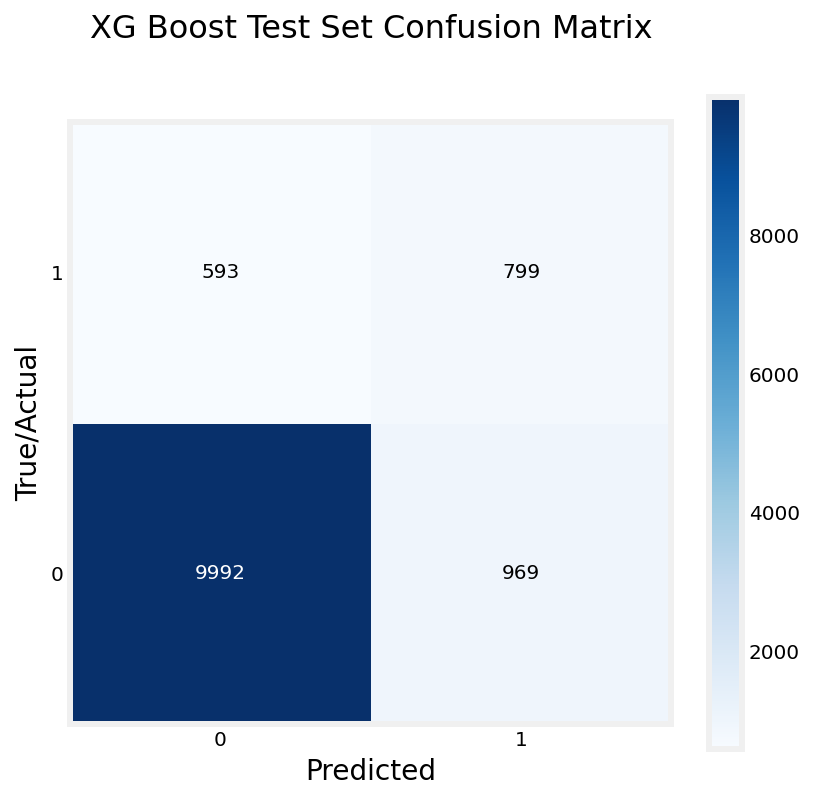

In [55]:
# XGB confusion matrix on test set
skplt.metrics.plot_confusion_matrix(y_test, xgb_test_class, figsize=(6,6))
plt.title('XG Boost Test Set Confusion Matrix', y=1.12, fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True/Actual', fontsize=14)
plt.ylim([-0.5, len(y.unique())-0.5])
plt.show()

In [56]:
print(metrics.classification_report(y_test, xgb_test_class))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     10961
           1       0.45      0.57      0.51      1392

    accuracy                           0.87     12353
   macro avg       0.70      0.74      0.72     12353
weighted avg       0.89      0.87      0.88     12353

